In [1]:
import numpy as np 
import pandas as pd 
import cv2

import matplotlib.pyplot as plt 
import matplotlib.image as mpimg

import torch 
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision

import pretrainedmodels
import pretrainedmodels.utils

import ssl 
from pathlib import Path
from imgaug import augmenters as iaa


# Disable SSL certificate verification
ssl._create_default_https_context = ssl._create_unverified_context

# Since we don't have CPU
map_location=torch.device('cpu')

# Load the model 

In [2]:
class PretrainedResnetApparealDS():
    """
        This class loads the model architecture with the specific weights computed during 
        the training for the age estimation task.
        
        Parmeters : 
            - weights_path (str) : the path to the object .pth containing the weights of the trained model 
            - model_name (str) : the name of the pretrained model from which we get the architecture of our model
            - num_classes (int) : the number of classes of the classifictaion task
            - pretrained (str) : specifies to only retrieve the architecture of the pretained model
            - model (obj) : the model with the correct architecture and weights that we will use
    """ 
    
    def __init__(self, weights_path = 'weights_finetuned.pth'): 
        self.weights_path = weights_path
        self.model_name = "se_resnext50_32x4d"
        self.num_classes = 101
        self.pretrained = None
        self.model = self.apply_finetuned_weights_to_model()
        
    def get_model_architecture(self):
        """ 
            Loads the architecture of the original pretrained model.
        """
        model = pretrainedmodels.__dict__[self.model_name](pretrained=self.pretrained)
        dim_feats = model.last_linear.in_features
        model.last_linear = nn.Linear(dim_feats, self.num_classes)
        model.avg_pool = nn.AdaptiveAvgPool2d(1)
        return  model 

    def load_finetuned_weights(self):
        """
            Load the weights of the model fine tuned during the training (done on Onixya).
        """
        return torch.load(self.weights_path, map_location="cpu")
    
    def apply_finetuned_weights_to_model(self):
        """ 
            Applies the weights to the architecture of the initial model and return the final model.
        """
        model = self.get_model_architecture()
        weights = self.load_finetuned_weights()
        model.load_state_dict(weights['state_dict'])
        return model 

In [3]:
# Intanciate a class and retrived the model with the lattest fine tunned weights for the avg
pretrained_resnest_appareal_ds = PretrainedResnetApparealDS()
model = pretrained_resnest_appareal_ds.model

# Exploration
## 1. Pass an image to the model 

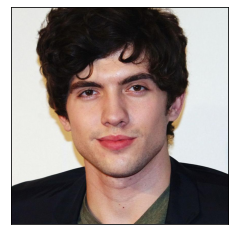

In [4]:
# Import a picture
image_test = mpimg.imread("appa-real-release/test/005616.jpg_face.jpg")
plt.imshow(image_test)
plt.xticks([])
plt.yticks([])
plt.show()

In [5]:
# Transfom the picture into a tensor
image_test_tensor = torch.from_numpy(image_test)
image_test_tensor = torch.permute(image_test_tensor, (2,0,1))
image_test_tensor = image_test_tensor.unsqueeze(0)
image_test_tensor = image_test_tensor.type(torch.float32)

In [6]:
# The model predict that the person is 28 years old
model(image_test_tensor).argmax()

tensor(28)

## 2. Compute an attack from an image and apply it

In [7]:
class ImageAttacked():
    """ 
        This class computes the attack on a specific image of a specific model, stores this attack and applies it 
        to any given image. 
        The goal is to see if an attack computed on an image can have an effective impact on another image.
        
        Parameters : 
            - model (object) : the pretrained model that will be attacked 
            - epsilon (float) : the  maximum pixel perturbation allowed
            - attack (tensor) : the tensor correspondong to the attack computed (i.e. an image)
            - attack_done (bool) : True if an attack was already computed
    """
    def __init__(self, model, epsilon : float):
        self.model = model 
        self.espsilon = epsilon
        self.attack = None
        self.attack_done = False
    
    def get_image(self, datatset : str, image_file_name : str) :
        """ 
                This function returns the image converted into a tensor. 
                
                Parameters : 
                    - datatset (string) : specifies the dateset of the image (e.g. train, valid or test)
                    - image_file_name (string) : file name of the image
        """
        # Load the image 
        image = mpimg.imread(f"appa-real-release/{datatset}/{image_file_name}")
        
        # Transfom the picture into a tensor
        image_tensor = torch.from_numpy(image)
        image_tensor = torch.permute(image_tensor, (2,0,1))
        image_tensor = image_tensor.unsqueeze(0)
        image_tensor = image_tensor.type(torch.float32)
        
        return image_tensor
        
    def get_image_real_age(self, datatset : str, image_file_name : str) : 
        """ 
                This function returns the real age of a person from a specific image. 
                
                Parameters : 
                    - datatset (string) : specifies the dateset of the image (e.g. train, valid or test)
                    - image_file_name (string) : file name of the image
        """
        df = pd.read_csv(f"appa-real-release/gt_avg_{datatset}.csv")

        if "face" in image_file_name : 
                # Retrive the correct file name 
                image_file_name = image_file_name.split("_")[0]
            
        return df[df.file_name == image_file_name].real_age.values[0]

    def compute_attack(self,  datatset : str, image_file_name : str) : 
        """ 
                This function computes the attack on a specific image and store the attack in self.attack.
                It returns the attack (tensor).
                
                Parameters : 
                    - datatset (string) : specifies the dateset of the image (e.g. train, valid or test)
                    - image_file_name (string) : file name of the image
        """     

        # Get the image converted into a tensor 
        image_tensor = self.get_image(datatset, image_file_name)
        
        # Get the real age of the image (type : integer)
        real_age = self.get_image_real_age(datatset, image_file_name).item()

        # Create a copy of the original image to attack it and keep the original one for comparaison
        attacked_img_tensor = image_tensor.detach().clone()

        # Enable the grandient computation on the image itself
        attacked_img_tensor.requires_grad = True

        # Get the probability for each of the 101 classes computed by the model 
        output = self.model(attacked_img_tensor)

        # Compute the cross entropy loss
        loss = - torch.nn.functional.cross_entropy(output, torch.LongTensor([real_age]))

        self.model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect gradient of the image
        grad = attacked_img_tensor.grad.data

        # Compute the attack (same shape as the original image) and store it
        self.attack = self.espsilon * grad.sign()
        self.attack_done = True

        return self.attack
        
        
            
    def apply_attack_to_image(self,  datatset : str, image_file_name : str, show = False): 
        """ 
                This function applies the attack (previously computed) on a specific image (can be deifferent
                from the image that was used to compute the attack). 
                It returns the attacked image tensor.
                
                Parameters : 
                    - datatset (string) : specifies the dateset of the image (e.g. train, valid or test)
                    - image_file_name (string) : file name of the image
                    - show (bool) : displays the original image, the attack and the attacked image if set to True
        """
        
        # If no attack is registered in the class, compute the attack based on the image on which you want to apply this attack
        if not self.attack_done : 
            self.compute_attack(datatset, image_file_name)
            
        # Get the image converted into a tensor
        image_tensor = self.get_image(datatset, image_file_name)
        
        # Resize the attack with the height and the width of the image on which you want to apply the attack
        attack_resized = torchvision.transforms.functional.resize(img = self.attack, size = [image_tensor.shape[2],image_tensor.shape[3]])
        
        # Apply the attack to the image
        attacked_img_tensor = image_tensor + attack_resized
        
        # Get the real age of the image (type : integer)
        real_age = self.get_image_real_age(datatset, image_file_name).item()
        
        # Get the prediction of the model on the original image
        original_prediction = self.model(image_tensor).argmax()
        
        # Get the prediction of the model on the attacked image
        attacked_prediction = self.model(attacked_img_tensor).argmax()

        if show : 
            fig, axes = plt.subplots(1,3, figsize = (9,4))
            
           # Display origian image
            axes[0].imshow((image_tensor/255).squeeze().permute(1,2,0).detach().numpy())
            axes[0].set_title(f"Original image \nAge prediction = {original_prediction}")
            axes[0].set_xticks([])
            axes[0].set_yticks([])
            # Display attack
            axes[1].imshow(((self.attack)*255).squeeze().permute(1,2,0).detach().numpy(), cmap= 'gray')
            axes[1].set_title("Attack")
            axes[1].set_xticks([])
            axes[1].set_yticks([])
            # Display image attacked 
            axes[2].imshow((attacked_img_tensor/255).squeeze().permute(1,2,0).detach().numpy())
            axes[2].set_xticks([])
            axes[2].set_yticks([])
            axes[2].set_title(f"Attacked image \nAge prediction = {attacked_prediction}")
            
            # Display the real age 
            fig.suptitle(f"Real age = {real_age}")
    
        return attacked_img_tensor

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


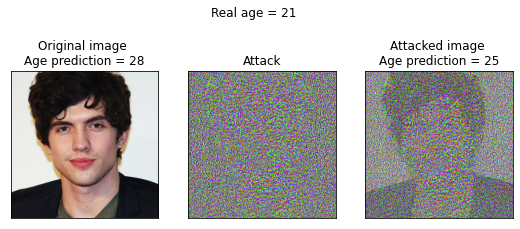

In [8]:
attack = ImageAttacked(model = model, epsilon = 200)
# Compute the attack on a image and apply the attack on the same image
image_attacked = attack.apply_attack_to_image("test", "005616.jpg_face.jpg", show=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


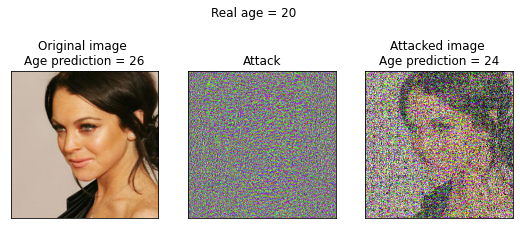

In [9]:
# Apply the same attack (resized) to another image
image_attacked_2 = attack.apply_attack_to_image("test", "007611.jpg_face.jpg", show=True)

## 3. Create attack transformation class for the data loader

In [10]:
class WhiteBoxTransformation():
    """ 
      This class computes and applies a white box attack on any image given as an input.
      The idea is to alter the image until the age prediction becomes bad enough.
      
    Parameters : 
        - model (object) : the pretrained model on which we will apply the white box attack
        - epsilon (float) : the maximum pixel perturbation allowed per step
        - min_age_diff (int) : the minimum difference between the age prediction of the original image and
                               the age prediction of attackedimage
    """
    def __init__(self, model, epsilon : float, min_age_diff : int):
        self.model = model 
        self.espsilon = epsilon
        self.min_age_diff = min_age_diff
        
    def compute_apply_white_box_attack(self, image_tensor, real_age, show = False) : 
        """
            This function computes the white box attack (based on the slef.model) on a image by 
            doing a gradient ascent. 
    
            Parameters : 
                - image_tensor (tensor) : the image on which the attack will be computed and then applied
                - real_age (integer) : the real age of the person (from 0 to 101)
                - show (bool) : displays the original image, the attack and the attacked image if set to True
        """
        print("attcking")
        self.model.eval()
        # Get the prediction of the model on the original image
        original_prediction = self.model(image_tensor).argmax()
        
        # Create a copy of the original image to attack it and keep the original one for comparaison (visualisation)
        attacked_img_tensor = image_tensor.detach().clone()

        # Enables the grandient computation on the image itself
        attacked_img_tensor.requires_grad = True

        # ---------------------------- LOOP ------------------------------
        # Loop until the difference between the predicted age on the attacked image and 
        # the original age prediction becomes greater then self.min_age_diff
        
        step = 1
        max_step = 10
        while True : 
            
            # Display the step during computaion
            print(f'Step {step}', end='\r')
            step += 1
            
            # Get the probability for each of the 101 classes computed by the model 
            output = self.model(attacked_img_tensor)

            # Compute the cross entropy loss
            loss = - torch.nn.functional.cross_entropy(output, torch.LongTensor([real_age]))
            
            self.model.zero_grad()

            # Calculate gradients of model in backward pass
            loss.backward()

            # Collect gradient of the image
            grad = attacked_img_tensor.grad.data

            # Compute the attack
            attack = self.espsilon * grad.sign()
            
            # Apply the attack to the original image
            attacked_img_tensor = attacked_img_tensor + attack
            
            # Get the prediction of the model on the attacked image
            attacked_prediction = self.model(attacked_img_tensor).argmax()
            
            # Recreate a copy of the image attacked to reset the .requires_grad to True for the next step
            attacked_img_tensor = attacked_img_tensor.detach().clone() 
            attacked_img_tensor.requires_grad = True
            
            if (self.min_age_diff <= abs(attacked_prediction - original_prediction)) or (step > max_step):
                break 
        
        if show : 
            fig , axes = plt.subplots(1,3, figsize = (9,4))
            
            # Display origian image
            axes[0].imshow((image_tensor/255).squeeze().permute(1,2,0).detach().numpy())
            axes[0].set_title(f"Original image \nAge prediction = {original_prediction}")
            axes[0].set_xticks([])
            axes[0].set_yticks([])
            # Display attack
            axes[1].imshow(((image_tensor-attacked_img_tensor)*255).squeeze().permute(1,2,0).detach().numpy(), cmap= 'gray')
            axes[1].set_title("Attack")
            axes[1].set_xticks([])
            axes[1].set_yticks([])
            # Display image attacked 
            axes[2].imshow((attacked_img_tensor/255).squeeze().permute(1,2,0).detach().numpy())
            axes[2].set_xticks([])
            axes[2].set_yticks([])
            axes[2].set_title(f"Attacked image \nAge prediction = {attacked_prediction}")
            
            # Display the real age 
            fig.suptitle(f"Real age = {real_age}")
            
        return attacked_img_tensor
      

attcking


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


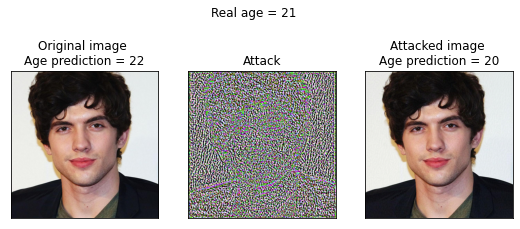

In [11]:
white_box_transformation = WhiteBoxTransformation(model = model, epsilon= 2, min_age_diff = 0)
attacked_image = white_box_transformation.compute_apply_white_box_attack(image_test_tensor, real_age=21, show = True)

# Création des DataSets et DataLoader

In [12]:
class ImgAugTransform:
    """
    A class to apply image augmentations with optional adversarial attack transformations.

    Attributes:
        attack_prop (float): The probability of applying the adversarial attack in augmentations.
        is_testor_val_set (bool): Flag to determine if the current dataset is for testing/validation.
                                  If True, simplifies the augmentation pipeline.
        white_box_transformation (WhiteBoxTransformation): An instance of WhiteBoxTransformation
                                                           used for adversarial attacks.
    """
    def __init__(self, attack_prop, is_testor_val_set, epsilon, min_age_diff):
        """
        Initializes the ImgAugTransform instance.

        Parameters:
            attack_prop (float): Probability of applying the adversarial attack. Default is 1.
            is_testor_val_set (bool): Specifies if the augmentations are for test/validation set. Default is False.
        """
        # Proportion of dataset images the attack is performed on 
        self.attack_prop = attack_prop
        self.is_testor_val_set = is_testor_val_set
        # Instanciation of the WhiteBox Attack : careful model needs to be defined : run Load Model part
        self.white_box_transformation = WhiteBoxTransformation(model = model, epsilon=epsilon, min_age_diff = min_age_diff)
        
    def keypoint_func(self, keypoints_on_images, random_state, parents, hooks):
        """
        !!!!!!!! Do not Change anything !!!!!!!!
        Copy Pasted for doc :  https://imgaug.readthedocs.io/en/latest/source/overview/meta.html?highlight=lambda
        Function to handle keypoints for imgaug augmentations. Currently a placeholder that returns inputs unchanged.

        Parameters:
            keypoints_on_images (list): List of image keypoints.
            random_state (ia.random.RandomState): Random state for deterministic transformations.
            parents (list): Information about the parents of this augmenter.
            hooks (HooksImages): Hooks to modify behavior of augmentations.

        Returns:
            The unchanged keypoints_on_images.
        """
        return keypoints_on_images
    
    def img_attack(self, images, random_state, parents, hooks):
        """
        Applies an adversarial attack to the images if the condition meets.

        Parameters:
            images (list of ndarray): List of images to be augmented.
            random_state (ia.random.RandomState): Random state for deterministic transformations.
            parents (list): Information about the parents of this augmenter.
            hooks (HooksImages): Hooks to modify behavior of augmentations.

        Returns:
            List of ndarray: Augmented images after applying the adversarial attack.
        """
        for idx, img in enumerate(images):
            if self.age > 0:
                # Make a copy to be sure we modify the right object
                img_tensor = img.copy()
                # Convertion to torch tensor as the attack use the model which needs tensors
                image_tensor = torch.from_numpy(img_tensor)
                image_tensor = torch.permute(image_tensor, (2,0,1))
                image_tensor = image_tensor.unsqueeze(0)
                image_tensor = image_tensor.type(torch.float32)
                # Compute the attack
                image_tensor = self.white_box_transformation.compute_apply_white_box_attack(image_tensor, real_age=int(self.age))
                # Convertion inverse to put the image back into a numpy ndarray because imgaug force it !!!!
                image_tensor = image_tensor.squeeze().detach().permute(1,2,0).numpy().astype(np.uint8)
                # Modifiy the image at index idx into the list of image
                images[idx] = image_tensor
        return images

    def construct_augmentation_pipeline(self):
        """
        Constructs the augmentation pipeline based on whether it is for a test/validation set.
        """
        if self.is_testor_val_set:
            # Implement only the attack because we do not augment validation or test sets
            self.aug = iaa.Sequential([
                iaa.Sometimes(self.attack_prop, iaa.Lambda(self.img_attack, self.keypoint_func)),
            ])
        else:
            self.aug = iaa.Sequential([
            iaa.OneOf([
                iaa.Sometimes(0.25, iaa.AdditiveGaussianNoise(scale=0.1 * 255)),
                iaa.Sometimes(0.25, iaa.GaussianBlur(sigma=(0, 3.0)))
                ]),
            iaa.Affine(
                rotate=(-20, 20), mode="edge",
                scale={"x": (0.95, 1.05), "y": (0.95, 1.05)},
                translate_percent={"x": (-0.05, 0.05), "y": (-0.05, 0.05)}
            ),
            iaa.AddToHueAndSaturation(value=(-10, 10), per_channel=True),
            iaa.GammaContrast((0.3, 2)),
            iaa.Fliplr(0.5),
            # Add the attack to imgaug pipeline with probability self.attack_prop
            iaa.Sometimes(self.attack_prop, iaa.Lambda(self.img_attack, self.keypoint_func)),
        ])
    
    
    def __call__(self, img, age):
        """
        Applies the constructed augmentation pipeline to the given image.

        Parameters:
            img (ndarray): The image to augment.
            age (int): The age to use in the attack as the true label.

        Returns:
            ndarray: The augmented image.
        """
        self.age = age  
        self.construct_augmentation_pipeline()
        img = np.array(img)
        img = self.aug.augment_image(img)
        return img

In [13]:
class FaceDataset(Dataset):
    """
    A dataset class for facial images, supporting augmentation and adversarial attack simulations.

    Attributes:
        data_dir (str): Directory where the dataset is located.
        data_type (str): The type of data (train, valid, test).
        attack_prop (float): Probability of applying an adversarial attack on each image. Defaults to 0.
        img_size (int): The size to which each image is resized. Defaults to 224.
        augment (bool): Flag indicating whether to apply augmentation. Defaults to False.
        age_stddev (float): Standard deviation multiplier for age noise. Defaults to 1.0.
    """
    
    def __init__(self, data_dir, data_type, attack_prop, epsilon, min_age_diff, img_size=224, age_stddev=1.0):
        assert data_type in ("train", "valid", "test"), "data_type must be one of 'train', 'valid', or 'test'"
        self.data_type = data_type
        self.img_size = img_size
        self.age_stddev = age_stddev
        self.attack_prop = attack_prop
        self.epsilon = epsilon
        self.min_age_diff = min_age_diff

        # Load dataset metadata
        csv_path = Path(data_dir).joinpath(f"gt_avg_{data_type}.csv")
        img_dir = Path(data_dir).joinpath(data_type)
        
        # Initialize lists to store data paths, ages, and age standard deviations
        self.x, self.y, self.std = [], [], []
        df = pd.read_csv(str(csv_path))
        
        # Optionally, ignore certain images
        ignore_path = Path("./").resolve().joinpath("ignore_list.csv")
        ignore_img_names = pd.read_csv(str(ignore_path))["img_name"].values
        
        # Filter and store relevant data
        for _, row in df.iterrows():
            img_name = row["file_name"]
            if img_name in ignore_img_names:
                continue

            img_path = img_dir.joinpath(img_name + "_face.jpg")
            assert img_path.is_file(), f"File {img_path} does not exist"
            self.x.append(str(img_path))
            self.y.append(row["apparent_age_avg"])
            self.std.append(row["apparent_age_std"])

    def __len__(self):
        """
        Returns the size of the dataset.

        Returns:
            int: The number of images in the dataset.
        """
        return len(self.y)

    def __getitem__(self, idx):
        """
        Retrieves the item at the specified index from the dataset.

        Parameters:
            idx (int): The index of the item.

        Returns:
            tuple: A tuple containing the processed image tensor and the associated age.
        """
        img_path = self.x[idx]
        age = self.y[idx]            

        # Load and preprocess the image
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (self.img_size, self.img_size))
        
        # Apply transformations with or without adversarial attacks based on the dataset type
        if self.data_type in ["valid", "test"]:
            transform = ImgAugTransform(
                attack_prop=self.attack_prop,
                epsilon=self.epsilon,
                min_age_diff=self.min_age_diff,
                is_testor_val_set=True,
            )
        else:
            # Apply random noise to the age based on the standard deviation if augmenting
            age += np.random.randn() * self.std[idx] * self.age_stddev
            transform = ImgAugTransform(               
                attack_prop=self.attack_prop,
                epsilon=self.epsilon,
                min_age_diff=self.min_age_diff,
                is_testor_val_set=False
            )
        img = transform(img, np.clip(round(age), 0, 100)).astype(np.float32)
        
        # Return the processed image and age
        return torch.from_numpy(np.transpose(img, (2, 0, 1))), np.clip(round(age), 0, 100)

### Create some datasets to verify the attack is well performed

Here we used attack_prop = 1., epsilon = 20 and min_age_diff = 10, to be sure that the attack will be visible as we wanted to be sure it was well performed. For testing phase we need to create attack which are not visible by human !

In [14]:
mock_train_dataset = FaceDataset("./appa-real-release/", "train",
                                 attack_prop=1., epsilon=20, min_age_diff=10, age_stddev=1.0)
mock_train_loader = DataLoader(mock_train_dataset, batch_size=2, shuffle=True, drop_last=True)

mock_val_dataset = FaceDataset("./appa-real-release/", "valid",
                               attack_prop=1., epsilon=20, min_age_diff=10)
mock_val_loader = DataLoader(mock_val_dataset, batch_size=2, shuffle=False, drop_last=False)

mock_test_dataset = FaceDataset("./appa-real-release/", "test",
                                attack_prop=1., epsilon=20, min_age_diff=10)
mock_test_loader = DataLoader(mock_test_dataset, batch_size=2, shuffle=False, drop_last=False)

### See the attack added to the image

attcking
attcking


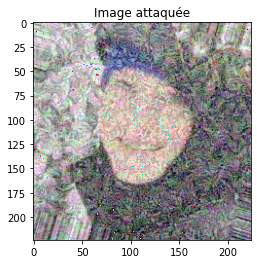

In [15]:
import matplotlib.pyplot as plt
for (x, y) in mock_train_loader:
    plt.imshow((cv2.cvtColor((x[0]/255).permute(1,2,0).numpy(), cv2.COLOR_BGR2RGB)))
    plt.title(f"Image attaquée")
    break

attcking
attcking


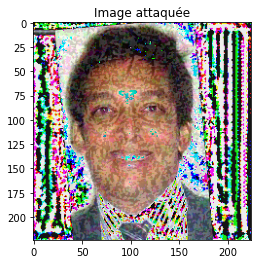

In [16]:
import matplotlib.pyplot as plt
for (x, y) in mock_val_loader:
    plt.imshow((cv2.cvtColor((x[0]/255).permute(1,2,0).numpy(), cv2.COLOR_BGR2RGB)))
    plt.title(f"Image attaquée")
    break

attcking
attcking


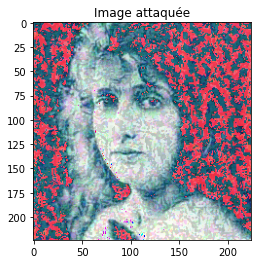

In [17]:
import matplotlib.pyplot as plt
for (x, y) in mock_test_loader:
    plt.imshow((cv2.cvtColor((x[0]/255).permute(1,2,0).numpy(), cv2.COLOR_BGR2RGB)))
    plt.title(f"Image attaquée")
    break

# Test the performance on the model with attacked images

# TO DO : 
1.  faire une montée de gradient (en déduirre une transformation) : une image test vs toutes les images test avec transformation spécifique => DONE
1.  modidifier toutes les images si on calcule qu'une seule attaque (sur une seule image)
2. tester le modèle avec ces images attaquées et voir si MEA à augmenter
3. attaquer tous les images train et ré-entraîner le modèle sur Onixia (avec du gros GPU sa mère)
4. retester sur les images test que l'on avait et celle qui ne le sont pas pour voir si 